In [122]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [170]:
def draw(image, locations, w, h, color=(0, 255, 0), thickness=1):
    for pt in zip(*locations[::-1]):
        _pt = (int(pt[2]), int(pt[3]))
        cv2.rectangle(image, _pt, (int(_pt[0] + pt[0]), int(_pt[1] + pt[1])), (0, 0, 0), 10)
    return image, len(locations[0])

In [171]:
def template_matching(image, template, down_threshold=0.65, up_threshold=1, 
                      resize_temp=False, min_scale=0.8, max_scale=1.0, num_scales=50):
    """
    Hàm thực hiện template matching để tìm mẫu trong ảnh.
    
    Tham số:
    - image: Ảnh lớn.
    - template: Ảnh mẫu.
    - threshold (float): Ngưỡng xác định độ khớp (mặc định là 0.8).

    Trả về:
    - image: Ảnh đã được tô đen vùng khớp.
    - locations: Danh sách tọa độ các vùng khớp.
    """
    image = image
    template = template

    if resize_temp:
        scales = np.linspace(min_scale, max_scale, num_scales)
        locations = [np.empty(0), np.empty(0), np.empty(0), np.empty(0)]

        for f in scales:
            resized_template = cv2.resize(template, None, fx=f, fy=f)
            result = cv2.matchTemplate(image, resized_template, cv2.TM_CCOEFF_NORMED)

            loc = np.where((up_threshold >= result) & (result >= down_threshold))
            locations[0] = np.concatenate([locations[0], loc[0]])
            locations[1] = np.concatenate([locations[1], loc[1]])
            locations[2] = np.concatenate([locations[2], np.array([resized_template.shape[0] for _ in range(len(loc[0]))])])
            locations[3] = np.concatenate([locations[3], np.array([resized_template.shape[1] for _ in range(len(loc[0]))])])
            
    else:
        result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
        locations = np.where((up_threshold >= result) & (result >= down_threshold))

    return image, locations

In [172]:
def show_img(image, title=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')  # Tắt hiển thị trục
    plt.title(title)
    plt.show()

In [173]:
def detect_edges(image, low_threshold=50, high_threshold=150):
    """
    Phát hiện cạnh trong ảnh sử dụng Canny Edge Detection.
    - low_threshold: Ngưỡng thấp để phát hiện cạnh yếu.
    - high_threshold: Ngưỡng cao để phát hiện cạnh mạnh.
    """
    edges = cv2.Canny(image, low_threshold, high_threshold)
    return edges

In [174]:
def process_match(image, x, y, w, h, locations, temp_img=None, down_threshold=0.65, up_threshold=1, 
                  resize_temp=False, min_scale=0.8, max_scale=1.2, num_scales=21, 
                  inheritance=True):
    if temp_img is None:
        temp_img = image.copy()
    crop_img = temp_img[y:y+h, x:x+w].copy()

    image, loc = template_matching(image, crop_img, down_threshold, up_threshold, 
                                   resize_temp, min_scale, max_scale, num_scales)
    if inheritance:
        locations[0] = np.concatenate([locations[0], loc[0]])
        locations[1] = np.concatenate([locations[1], loc[1]])
        locations[2] = np.concatenate([locations[2], loc[2]])
        locations[3] = np.concatenate([locations[3], loc[3]])
        return image, locations
    return image, loc

In [175]:
def filter(list_point, max_dis=11):
    filtered_points = []

    for p in list_point:
        add = True
        for fp in filtered_points:
            if p[2] - fp[2] <= max_dis and p[3] - fp[3] <= max_dis:
                add = False
        if add:
            filtered_points.append(p)
    return  filtered_points

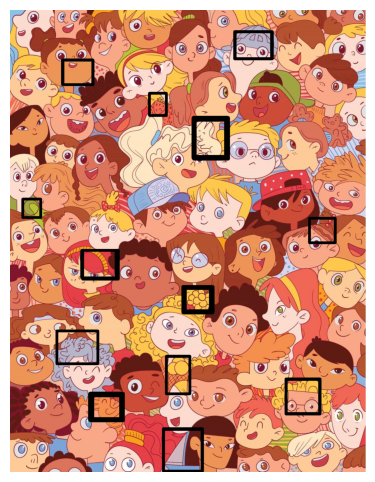

In [176]:
# 1.jpg
image = cv2.imread('1.jpg')[:, :1408]
image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_edges = detect_edges(image_grey)

thing = cv2.imread('1.jpg')[:, 1408:]
thing_grey = cv2.cvtColor(thing, cv2.COLOR_BGR2GRAY)
thing_edges = detect_edges(thing_grey)

locations = [np.empty(0), np.empty(0), np.empty(0), np.empty(0)]

x, y = 102, 923
w, h = 129, 207 # kem ok
_image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.4, temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.7, max_scale=0.8,
                                       num_scales=30)

x, y = 310, 901
w, h = 213, 232 # thuyền ok
_image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.4, temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.7, max_scale=0.8,
                                       num_scales=30)

x, y = 559, 952
w, h = 204, 149 # ô tô ok
_image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.4, temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.7, max_scale=0.8,
                                       num_scales=30)

x, y = 842, 930
w, h = 191, 154 # bóng bay ok
_image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.100577, up_threshold=0.100578,
                                       temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.7, max_scale=0.8,
                                       num_scales=30)

x, y = 97, 1185
w, h = 222, 178 # ngựa ok
_image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.070003, up_threshold=0.070005,
                                       temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.7, max_scale=0.8,
                                       num_scales=30)
                                       
x, y = 440, 1230
w, h = 156, 115 # dưa (từ bỏ vì quá nhỏ và quá lâu)
_image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.7, up_threshold=0.07,
                                       temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.7, max_scale=0.8,
                                       num_scales=30)
                                       
x, y = 711, 1146
w, h = 186, 191 # tàu ok
_image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.4, temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.7, max_scale=0.8,
                                       num_scales=30)
                                       
x, y = 111, 1421
w, h = 150, 133 # nho ok
_image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.15, temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.7, max_scale=0.8,
                                       num_scales=30)
                                       
x, y = 368, 1421
w, h = 159, 97 # nơ (từ bỏ vì quá nhỏ và quá lâu)
_image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.7, up_threshold=0.06,
                                       temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.5, max_scale=0.6,
                                       num_scales=30)
                                       
x, y = 666, 1421
w, h = 141, 135 # bánh ok
_image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.10004, up_threshold=0.100045,
                                       temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.7, max_scale=0.8,
                                       num_scales=30)
                                       
x, y = 923, 1328
w, h = 154, 205 # gấu ok
_image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.4, temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.7, max_scale=0.8,
                                       num_scales=30)
                                       
x, y = 123, 1613
w, h = 102, 104 # tennis ok
_image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.150065, up_threshold=0.150067, 
                                       temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.7, max_scale=0.8,
                                       num_scales=30)
                                       
x, y = 360, 1600
w, h = 96, 125 # dâu ok
_image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.1022195, up_threshold=0.1022197, 
                                       temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.7, max_scale=0.8,
                                       num_scales=30)
                                       
x, y = 581, 1545
w, h = 178, 213 # thỏ ok
_image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.15, temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.7, max_scale=0.8,
                                       num_scales=30)
                                       
x, y = 866, 1604
w, h = 167, 136 # vịt ok
_image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.15, temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.7, max_scale=0.8,
                                       num_scales=30)
                                       
# locations = filter(list(zip(*locations[::-1])))

# res_image = image.copy()
# for pt in locations:
#     _pt = (int(pt[2]), int(pt[3]))
#     cv2.rectangle(res_image, _pt, (int(_pt[0] + pt[0]), int(_pt[1] + pt[1])), (0, 0, 0), 10)

res_image = image.copy()
res_image, count = draw(res_image, locations, w, h, thickness=2)

show_img(res_image)

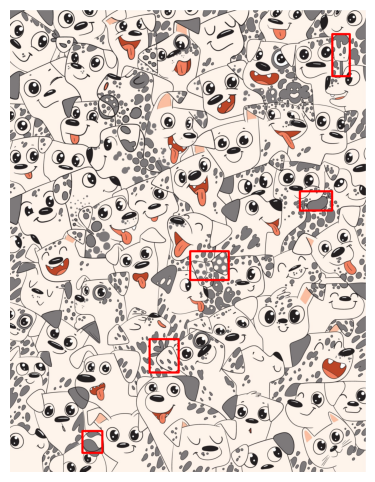

In [177]:
# 2.jpg
src = cv2.imread('2.jpg')[232:]

image = src[:, :1791]
image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_edges = detect_edges(image_grey)

thing = src[:, 1791:]
thing_grey = cv2.cvtColor(thing, cv2.COLOR_BGR2GRAY)
thing_edges = detect_edges(thing_grey)

locations = [np.empty(0), np.empty(0), np.empty(0), np.empty(0)]

x, y = 303, 76
w, h = 188, 216 # dâu
image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.4, temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.7, max_scale=0.8,
                                       num_scales=30)

x, y = 136, 275
w, h = 113, 272 # kem
image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.4, temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.7, max_scale=0.8,
                                       num_scales=30)

x, y = 442, 332
w, h = 231, 265 # bướm
image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.15, temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.7, max_scale=0.8,
                                       num_scales=30)

x, y = 54, 705
w, h = 230, 117 # xương
image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.4, temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.7, max_scale=0.8,
                                       num_scales=30)

x, y = 456, 650
w, h = 250, 187 # nơ
image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.4, temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.7, max_scale=0.8,
                                       num_scales=30)

x, y = 263, 980
w, h = 222, 133 # xúc xích
image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.4, temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.7, max_scale=0.8,
                                       num_scales=30)

x, y = 52, 1241
w, h = 204, 169 # ma
image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.4, temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.7, max_scale=0.8,
                                       num_scales=30)

x, y = 485, 1160
w, h = 166, 201 # ốc quế
image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.4, temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.7, max_scale=0.8,
                                       num_scales=30)

x, y = 211, 1549
w, h = 129, 142 # tennis
image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.4, temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.7, max_scale=0.8,
                                       num_scales=30)

x, y = 462, 1577
w, h = 136, 203 # phô mai
image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.4, temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.7, max_scale=0.8,
                                       num_scales=30)

x, y = 134, 1854
w, h = 175, 212 # gà
image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.4, temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.7, max_scale=0.8,
                                       num_scales=30)

x, y = 528, 2013
w, h = 143, 147 # bọ
image_edges, locations = process_match(image_edges, x, y, w, h, locations, down_threshold=0.4, temp_img=thing_edges,
                                       resize_temp=True, min_scale=0.7, max_scale=0.8,
                                       num_scales=30)


locations = filter(list(zip(*locations[::-1])))

res_image = image.copy()
for pt in locations:
    _pt = (int(pt[2]), int(pt[3]))
    cv2.rectangle(res_image, _pt, (int(_pt[0] + pt[0]), int(_pt[1] + pt[1])), (0, 0, 255), 10)

show_img(res_image)